# Stationary multi-armed bandit

In the stationary case the reward probability $p_{t, l}$ is fixed, hence $p_{t,l} = p_l$, $ \forall t \in \{1, T\}$. We will consider here the variant of the problem in which all but the best arm have the same reward probability $p$, and the best arm is defined as $p_{max} = p + \epsilon$.

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-notebook')
sns.set(color_codes=True)

mpl.rcParams['figure.figsize'] = [15, 5]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 300

In [7]:
# define the generative process for rewards and outcomes with zero change probability
import jax.numpy as np
from jax import random, lax, nn, ops

rho = .0

log_pj_j = np.log(np.array([[1 - rho, rho], [1, 0]]))

def process(t, choices, states, rng_key):
    probs, changes = states
    
    N = len(choices)
    K = len(probs)
    
    rng_key, _rng_key = random.split(rng_key)
    new_change = random.categorical(_rng_key, log_pj_j[changes])
    
    rng_key, _rng_key = random.split(rng_key)
    random_probs = random.uniform(_rng_key, shape=(K,))
    
    new_probs = np.where(new_change, random_probs, probs)
   
    rng_key, _rng_key = random.split(rng_key)
    outcomes = random.bernoulli(_rng_key, probs, shape=(N, K))
    
    return outcomes, [new_probs, new_change]

## Bayesian inference

Given the constrain of this investigation to the Bernoulli bandits we will define the observation likelihood as 

$$ p(o_t|\vec{\theta}, s_t) = \prod_{k=1}^K \left[ \theta_k^{o_{t}}\left( 1- \theta_k \right)^{1-o_{t}} \right]^{\delta_{s_t, k}}  $$

In both cases we can assume that the prior over reward probabilities is given as the product of conjugate priors of the Bernoulli distribution, that is, the Beta distribution. Hence,

$$ p(\vec{\theta}|s_t) = \prod_{k=1}^K \left[ B(\theta_k; \alpha_{0,k}, \beta_{0,k}) \right]^{\delta_{s_t, k}}$$

where we assume that initial prior (before making any observations) corresponds to a uniform distribution, 
hence $\alpha_{0,k}, \beta_{0,k} = 1, \forall \: k$. Conjugacy of the prior allows us to define simple update rules

\begin{equation}
    \begin{split}
    \alpha_{t, k} &= \alpha_{t-1, k} + o_t \\
    \beta_{t, k} &= \beta_{t-1,k} + (1-o_t)
    \end{split}
\end{equation}

where the parameter update is performed only for a selected $k$th arm.

In [3]:
# define the learning rule
def learning(outcomes, choices, priors):
    
    N, K = outcomes.shape
    
    select_observed = np.eye(K)[choices]
    
    alpha_t = priors[..., 0] + select_observed * outcomes
    beta_t = priors[..., 1] + select_observed * (1 - outcomes)
        
    return np.stack([alpha_t, beta_t], -1)

## Action selection

### Thompson sampling

This form of action selection algorithm is derived from the i.i.d samples from the reward probability prior
at trial $t$, hence

$$a_t = \arg\max_k \theta^*_k, \qquad \theta^*_k \sim Beta(\theta_k; \alpha_{t-1, k}, \beta_{t-1, k})$$

An extension of this often found in the literature, specially on dynamic MABs, is called optimistic 
Thompson sampling, and is defined as 

$$a_t = \arg\max_k \max(\theta^*_k, \mu_{t-1,k}), \qquad \theta^*_k \sim Beta(\theta_k; \alpha_{t-1, k}, \beta_{t-1, k})$$

where the expected reward probability $\mu_{t-1, k} = \frac{\alpha_{t-1,k}}{\alpha_{t-1,k} + \beta_{t-1, k} }$
constrains the minimal value of the sample from the prior.


### Upper confidence bound (UCB)

Another classical algorithm of reinforcement learning with a decision rule defined as

\begin{equation}
    a_t = \left\{ \begin{array}{cc}
        \arg\max_k \left(\mu_{k, t-1} + \sqrt{\frac{2 \ln t}{\nu_{k, t-1}-2}}\right) & \textrm{for } t>K \\
        t & \textrm{otherwise}
    \end{array}
    \right.
\end{equation}

where $\mu_{k, t-1} = \frac{\alpha_{t-1, k}}{\nu_{t-1, k}}$ and $\nu_{k, t-1} = \alpha_{t-1,k} + \beta_{t-1,k}$.  

### Active inference

The action selection in active inference rest upon the expected free energy $G(\pi)$ of behavioral policy $\pi$. Normally, behavioral policies in active inference correspond to a specific sequence of future actions $\pi = (a_{t}, \ldots, a_D)$ up to some planning depth $D$. Here we will limit the analysis to a shallow planning depth of $D=1$ hence each policy corresponds to one of the possible choices, that is actions $a_t$.
The expected free energy is defined as 

$$ G(a_t) = D_{KL}\left(Q(\vec{\theta}, s_t |a_t)||P(\vec{\theta}, s_t)\right) + E_{Q(\vec{\theta}, s_{t}|a_t)}\left[H[o_t|\vec{\theta}, s_t] \right]$$

where $P(\vec{\theta}, s_t)$ corresponds to a prior preference over hidden states, and $Q(\vec{\theta}, s_t |a_t)$ to the action dependent expectation in trial $t$, hence

$$Q(\vec{\theta}, s_t |a_t) = p(\theta|s_t, o_{1:t-1}) p(s_t|a_t) $$

The expected free energy corresponds forms an upper bound on the expected surprisial $S(a_t)$ defined as

\begin{equation}
    \begin{split}
    S(a_t) & =  D_{KL}\left(Q(o_t |a_t)||P(o_t)\right) + E_{Q(\vec{\theta}, s_{t}|a_t)}\left[H[o_t|\vec{\theta}, s_t] \right] \\
    & = - E_{Q(o_t|a_t)}\left[ \ln P(o_t) +  D_{KL}\left( Q(\vec{\theta}, s_t|o_t, a_t)|| Q(\vec{\theta}, s_t|a_t)\right) \right] \leq G(a_t)
    \end{split}
\end{equation}


where $Q(o_t|a_t) = \sum_{s_t} \int d \vec{\theta} p(o_t|\vec{\theta}, s_t) Q(\vec{\theta}, s_t|a_t)$, and

$$ Q(\vec{\theta}, s_t|o_t, a_t) \propto p(o_t|\vec{\theta}, s_t) Q(\vec{\theta}, s_t|a_t) $$

We will assume that the agent has not preferences over arms, hence $p(s_t) = \frac{1}{K}$. However, it does have preferences over reward probabilities, in a way that it prefers higher reward probabilities. We can express this as 

$$ P(\vec{\theta}|s_t) \propto \prod_k \theta_k^{\delta_{s_t, k} \left( \alpha-1 \right)}$$

From this we can obtain the marginal preference over outcomes as  

$$ P(o_t) = \sum_{s_t} \int d \vec{\theta} p(o_t|\vec{\theta}, s_t) P(\vec{\theta}, s_t) \propto e^{o_t \lambda} e^{-(1-o_t) \lambda}, \qquad \lambda = \frac{1}{2} \ln \alpha $$

We will consider to variants of the action selection rule, one based on the expected free energy and defined as 

$$ p(a_t) \propto e^{- \gamma G(a_t)},$$

and another based on expected surprisal and defined as

$$ p(a_t) \propto e^{- \gamma S(a_t)}.$$

The motivation for this differentiation comes from the fact that minimum of the expected free energy will not 
in general correspond to the minimum of the expected surprisal, hence 

$$ \arg\min_a G(a) \neq \arg\min_a S(a)$$

This way we can understand effects of the action selection objective function on behavior. Given the known functional expressions for the prior expectation $Q(\vec{\theta}, s_t| a_t)$, and $Q(o_t| a_t)$ prior preferences $P(\vec{\theta}, s_t)$, and $P(o_t)$, and observation likelihood $p(o_t|\vec{\theta}, s_t)$ we get the following expressions for expected free energy and expected surprisal 

\begin{equation}
    \begin{split}
    G(a_t = a) & = - \ln \left[ B(\alpha_{t-1, a}, \beta_{t-1, a})\right] + (\alpha_{t-1, a} - \alpha) \psi(\alpha_{t-1, a}) + (\beta_{t-1, a} - 1) \psi(\beta_{t-1, a}) + (\alpha + 1 - \nu_{t-1, a}) \psi(\nu_{t-1, a}) \\
    - & \mu_{t-1,a} \psi(\alpha_{t-1, a} + 1)
    - (1 - \mu_{t-1,a}) \psi(\beta_{t-1, a} + 1) + \psi(\nu_{t-1,a} + 1) \\
    S(a_t = a) & = - \lambda( 2 \cdot  \mu_{t-1, a} - 1) + \mu_{t-1, a} \ln \mu_{t-1, a} + (1-\mu_{t-1, a}) \ln ( 1- \mu_{t-1, a}) \\
    - & \mu_{t-1,a} \psi(\alpha_{t-1, a} + 1) - (1 - \mu_{t-1,a}) \psi(\beta_{t-1, a} + 1) + \psi(\nu_{t-1,a} + 1)
    \end{split}
\end{equation}

In [4]:
# implementation of decision algorithms
from jax.scipy.special import digamma, betaln

def thompson_selection(t, beliefs, rng_key):
    #Thompson sampling
    
    alpha_t = beliefs[..., 0]
    beta_t = beliefs[..., 1]
    
    thetas = random.beta(rng_key, alpha_t, beta_t)
    
    choices = thetas.argmax(-1) # select choices with maximal outcome probability
    
    return choices

def optimistic_selection(t, beliefs, rng_key):
    #Optimistic thompson sampling
    alpha_t = beliefs[..., 0]
    beta_t = beliefs[..., 1]
    
    mu_t = alpha_t / (alpha_t + beta_t)
    
    thetas = random.beta(rng_key, alpha_t, beta_t)
    
    choices = np.where(thetas > mu_t, thetas, mu_t).argmax(-1) # select choices with maximal outcome probability
    
    return choices

def ucb_selection(t, beliefs, rng_key):
    alpha_t = beliefs[..., 0]
    beta_t = beliefs[..., 1]
    
    nu_t = alpha_t + beta_t
    mu_t = alpha_t/nu_t
    
    N, K = beliefs.shape[:-1]
        
    choices1 = (mu_t + np.sqrt(2 * np.log(t)/(nu_t-2 + 1e-6))).argmax(-1)
    choices2 = t * np.ones(N, dtype=np.int32)
    
    return np.where(t > K, choices1, choices2)
    
def G(alpha_t, beta_t, alpha):
    nu_t = alpha_t + beta_t
    mu_t = alpha_t / nu_t
    
    KL_a = - betaln(alpha_t, beta_t) + (alpha_t - alpha) * digamma(alpha_t)\
             + (beta_t - 1) * digamma(beta_t) + (alpha + 1 - nu_t) * digamma(nu_t)
    
    H_a = - mu_t * digamma(alpha_t + 1) - (1-mu_t) * digamma(beta_t + 1) + digamma(nu_t + 1)
    
    return KL_a + H_a

def efe_selection(t, beliefs, rng_key, gamma=10, lam=1.):
    # expected free energy based action selection
    alpha_t = beliefs[..., 0]
    beta_t = beliefs[..., 1]
    
    alpha = np.exp(2 * lam)
    
    G_a = G(alpha_t, beta_t, alpha)
    
    choices = random.categorical(rng_key, - gamma * G_a) # sample choices
    return choices

def S(alpha_t, beta_t, lam):
    
    nu_t = alpha_t + beta_t
    mu_t = alpha_t / nu_t
    
    KL_a = - lam * (2 * mu_t - 1) + mu_t * np.log(mu_t) + (1-mu_t) * np.log(1-mu_t) 
    
    H_a = - mu_t * digamma(alpha_t + 1) - (1-mu_t) * digamma(beta_t + 1) + digamma(nu_t + 1)
    
    return KL_a + H_a
    
def sup_selection(t, beliefs, rng_key, gamma=10, lam=1.):
    # expected surprisal based action selection
    alpha_t = beliefs[..., 0]
    beta_t = beliefs[..., 1]
    
    S_a = S(alpha_t, beta_t, lam) 
    
    choices = random.categorical(rng_key, - gamma * S_a) # sample choices
    return choices

In [5]:
# implement simulator for POMDP

def simulator(process, learning, action_selection, N=100, T=1000, K=10, seed=0, eps=.25):
    def sim_fn(carry, t):
        rng_key, states, prior = carry
        
        rng_key, _rng_key = random.split(rng_key)
        choices = action_selection(t, prior, _rng_key)
        
        rng_key, _rng_key = random.split(rng_key)
        outcomes, states = process(t, choices, states, _rng_key)
        posterior = learning(outcomes, choices, prior)
                
        return (rng_key, states, posterior), {'outcomes': outcomes, 
                                              'choices': choices,
                                              'beliefs': posterior}
    
    rng_key = random.PRNGKey(seed)
    probs = np.concatenate([np.array([eps + .5]), np.ones(K-1)/2.])
    states = [probs, np.zeros(1, dtype=np.int32)]
    prior = np.ones((N, K, 2))
    
    _, sequence = lax.scan(sim_fn, (rng_key, states, prior), np.arange(T))
    
    return sequence

Before we compare active inference with Thompson sampling and UCB algorithm, we will illustrate how the values of action precision $\gamma$ and the precision of prior preferences $\lambda$ impact cumulative regret of the active inference agent.

In [8]:
N = 1000
T = 10000
eps = .25
K = 3

seed = random.PRNGKey(100)
gammas = np.arange(1., 21., 1.)
lambdas = np.arange(.0, 4., .2)

mean_reg = {'EFE': [], 'SUP': []}
for gamma in gammas:
    for lam in lambdas:
        for func, label in zip([efe_selection, sup_selection], ['EFE', 'SUP']):
            selection = lambda *args: func(*args, gamma=gamma, lam=lam)
            seed, _seed = random.split(seed)
            sequence = simulator(process, learning, selection, N=N, T=T, K=K, eps=eps, seed=_seed[0])

            choices = sequence['choices']
            mean_reg[label].append(np.cumsum((1 - (choices == 0).astype(np.float32)) * eps, 0).mean(-1)[-1]/T)

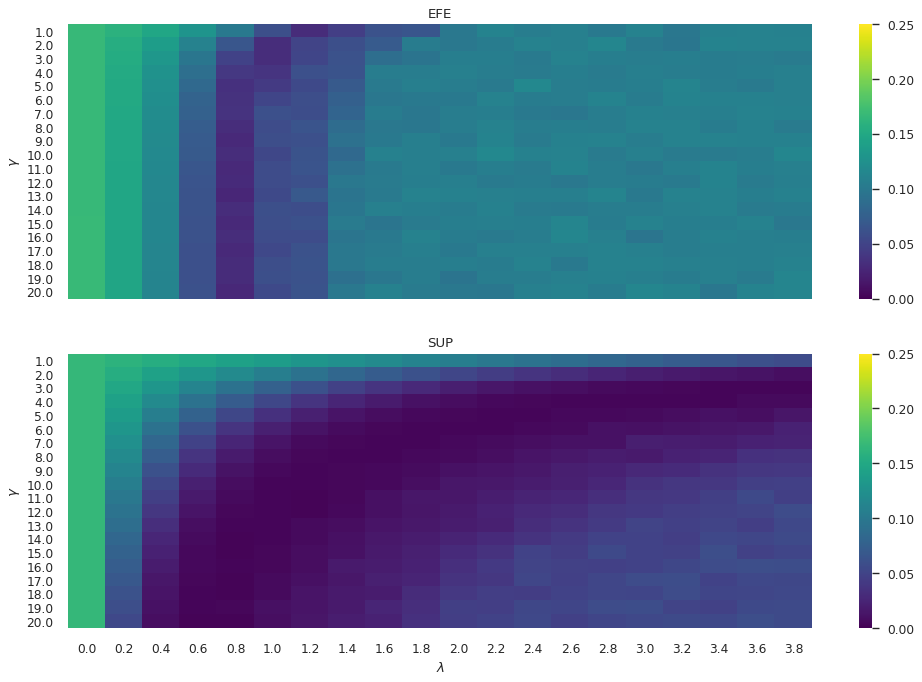

In [9]:
fig, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(15, 10))

sns.heatmap(np.array(mean_reg['EFE']).reshape(len(gammas), -1), vmin=0., vmax=.25, cmap='viridis', ax=axes[0])
sns.heatmap(np.array(mean_reg['SUP']).reshape(len(gammas), -1), vmin=0., vmax=.25, cmap='viridis', ax=axes[1])

axes[0].set_xticklabels(lambdas);
axes[1].set_xlabel(r'$\lambda$');

axes[0].set_title('EFE')
axes[1].set_title('SUP')
axes[0].set_yticklabels(gammas);
axes[0].set_ylabel(r'$\gamma$');
axes[1].set_ylabel(r'$\gamma$');

Above we show the expected regret rate defined as 

$$r(T) = \frac{1}{T} E[R(T)] = \frac{1}{N \cdot T} \sum_{n=1}^N \sum_{t=1}^T \left[p_{max} - p_{a_t^n}\right]$$

where the expectation $E[x]$ is computed over $N$ different runs for each pair of parameter values.

In [10]:
sequence1 = simulator(process, learning, thompson_selection, N=N, T=T, K=K, eps=eps)

sequence2 = simulator(process, learning, optimistic_selection, N=N, T=T, K=K, eps=eps)

sequence3 = simulator(process, learning, ucb_selection, N=N, T=T, K=K, eps=eps)

In [11]:
lam = .8
gamma = 15.
selection = lambda *args: efe_selection(*args, gamma=gamma, lam=lam)
sequence4 = simulator(process, learning, selection, N=N, T=T, K=K, eps=eps)

lam = .8
gamma = 15.
selection = lambda *args: sup_selection(*args, gamma=gamma, lam=lam)
sequence5 = simulator(process, learning, selection, N=N, T=T, K=K, eps=eps)

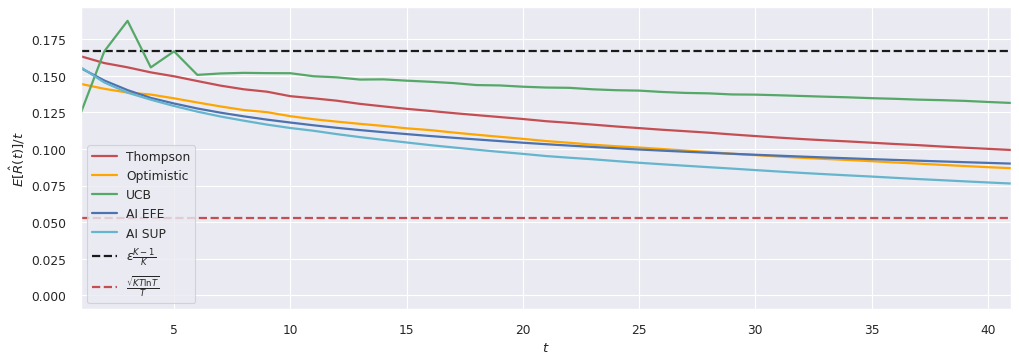

In [12]:
sequences = [sequence1, sequence2, sequence3, sequence4, sequence5]
labels = ['Thompson', 'Optimistic', 'UCB', 'AI EFE', 'AI SUP']
colors = ['r', 'orange', 'g', 'b', 'c']
fig, axes = plt.subplots(1, 1)
ts = np.arange(1., T+1)

max_prob = eps + .5
for i, sequence in enumerate(sequences):
    choices = sequence['choices']
    
    regret = np.cumsum((1 - (choices == 0).astype(np.float32)) * eps, 0)
    plt.plot(regret.mean(-1)/ts, c=colors[i], label=labels[i], lw=2)

plt.hlines(eps * (1 - 1/K), 1, T+1, 'k', linestyle='--', lw=2, label=r'$\epsilon \frac{K-1}{K}$')
plt.hlines(np.sqrt(K * T * np.log(T))/T, 1, T+1, 'r', linestyle='--', lw=2, label=r'$\frac{\sqrt{K T\ln T}}{T}$')
plt.legend();

plt.xlim([1, 40+1]);
plt.xlabel(r'$t$');
plt.ylabel(r'$E[\hat{R}(t)]/t$');

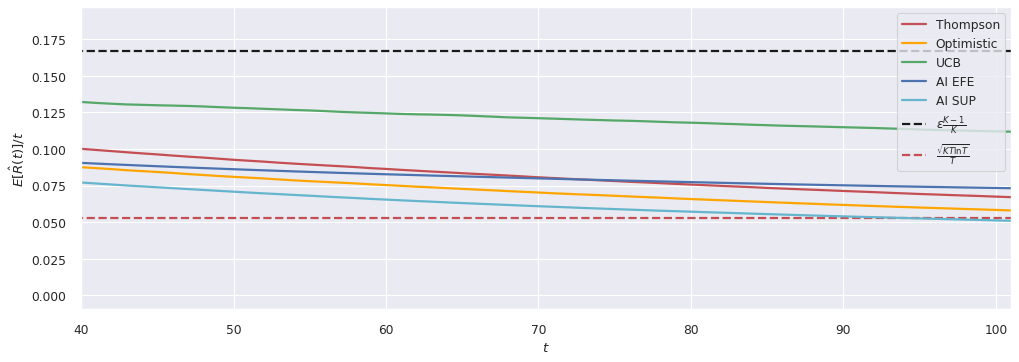

In [15]:
sequences = [sequence1, sequence2, sequence3, sequence4, sequence5]
labels = ['Thompson', 'Optimistic', 'UCB', 'AI EFE', 'AI SUP']
colors = ['r', 'orange', 'g', 'b', 'c']
fig, axes = plt.subplots(1, 1)
ts = np.arange(1., T+1)

max_prob = eps + .5
for i, sequence in enumerate(sequences):
    choices = sequence['choices']
    
    regret = np.cumsum((1 - (choices == 0).astype(np.float32)) * eps, 0)
    plt.plot(regret.mean(-1)/ts, c=colors[i], label=labels[i], lw=2)

plt.hlines(eps * (1 - 1/K), 1, T+1, 'k', linestyle='--', lw=2, label=r'$\epsilon \frac{K-1}{K}$')
plt.hlines(np.sqrt(K * T * np.log(T))/T, 1, T+1, 'r', linestyle='--', lw=2, label=r'$\frac{\sqrt{K T\ln T}}{T}$')
plt.legend();

plt.xlim([40, 100+1]);
plt.xlabel(r'$t$');
plt.ylabel(r'$E[\hat{R}(t)]/t$');

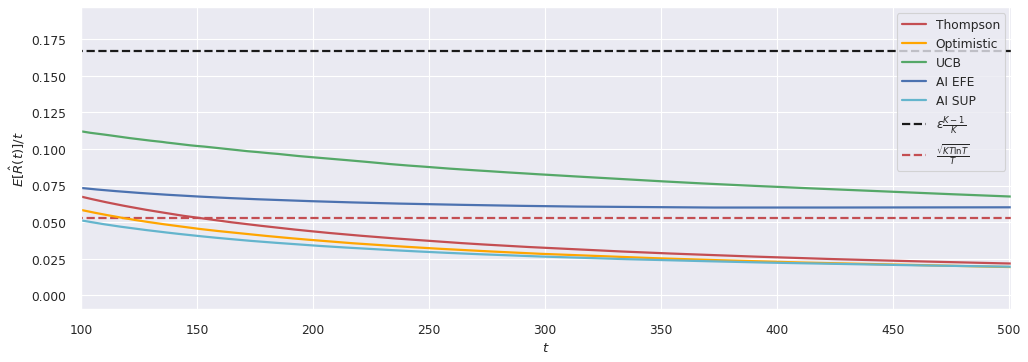

In [16]:
sequences = [sequence1, sequence2, sequence3, sequence4, sequence5]
labels = ['Thompson', 'Optimistic', 'UCB', 'AI EFE', 'AI SUP']
colors = ['r', 'orange', 'g', 'b', 'c']
fig, axes = plt.subplots(1, 1)
ts = np.arange(1., T+1)

max_prob = eps + .5
for i, sequence in enumerate(sequences):
    choices = sequence['choices']
    
    regret = np.cumsum((1 - (choices == 0).astype(np.float32)) * eps, 0)
    plt.plot(regret.mean(-1)/ts, c=colors[i], label=labels[i], lw=2)

plt.hlines(eps * (1 - 1/K), 1, T+1, 'k', linestyle='--', lw=2, label=r'$\epsilon \frac{K-1}{K}$')
plt.hlines(np.sqrt(K * T * np.log(T))/T, 1, T+1, 'r', linestyle='--', lw=2, label=r'$\frac{\sqrt{K T\ln T}}{T}$')
plt.legend();

plt.xlim([100, 500+1]);
plt.xlabel(r'$t$');
plt.ylabel(r'$E[\hat{R}(t)]/t$');

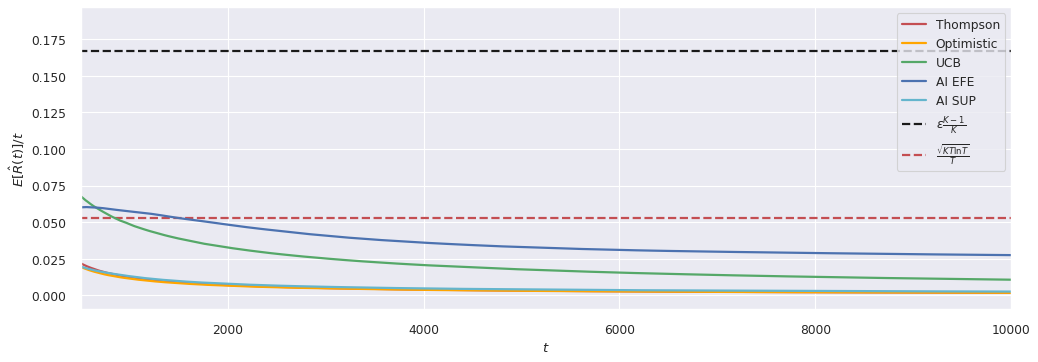

In [17]:
sequences = [sequence1, sequence2, sequence3, sequence4, sequence5]
labels = ['Thompson', 'Optimistic', 'UCB', 'AI EFE', 'AI SUP']
colors = ['r', 'orange', 'g', 'b', 'c']
fig, axes = plt.subplots(1, 1)
ts = np.arange(1., T+1)

max_prob = eps + .5
for i, sequence in enumerate(sequences):
    choices = sequence['choices']
    
    regret = np.cumsum((1 - (choices == 0).astype(np.float32)) * eps, 0)
    plt.plot(regret.mean(-1)/ts, c=colors[i], label=labels[i], lw=2)

plt.hlines(eps * (1 - 1/K), 1, T+1, 'k', linestyle='--', lw=2, label=r'$\epsilon \frac{K-1}{K}$')
plt.hlines(np.sqrt(K * T * np.log(T))/T, 1, T+1, 'r', linestyle='--', lw=2, label=r'$\frac{\sqrt{K T\ln T}}{T}$')
plt.legend();

plt.xlim([500, 10000+1]);
plt.xlabel(r'$t$');
plt.ylabel(r'$E[\hat{R}(t)]/t$');

### TODO:

* establish functional or numerical relationship between $\gamma^*$, $\lambda^*$ and $K$, $\epsilon$.
* for AI SUP algorithm figure out $\gamma^* = f(\lambda, K, \epsilon)$? 
* introduce learning of $\gamma$ and $\lambda$. Would the learning find values of $\lambda$, $\gamma$ that minimize regret?